In [1]:
%load_ext autoreload
%autoreload 2

In [51]:
import re
import numpy as np
import xarray as xr
import tensorflow.keras as keras
import datetime
import pdb
import matplotlib.pyplot as plt

In [8]:
datadir = '/data/stephan/WeatherBench/5.625deg/'

In [3]:
var_dict = {
    'geopotential': ('z', [500]),
    'temperature': ('t', [850]),
    'constants': ['lat2d', 'orography', 'lsm']
}

In [4]:
output_vars = ['z_500', 't_850']

In [10]:
ds = xr.merge([xr.open_mfdataset(f'{datadir}/{var}/*.nc', combine='by_coords') for var in var_dict.keys()])

In [15]:
ds_train = ds.sel(time=slice('2015', '2015'))
ds_valid = ds.sel(time=slice('2016', '2016'))
ds_test = ds.sel(time=slice('2017', '2018'))

In [16]:
lead_time=72
filters = [128, 128, 128, 128, 128, 128, 2]
kernels = [5, 5, 5, 5, 5, 5, 5]
norm_subsample = 60000
data_subsample = 1
lr = 0.5e-4
batch_size = 128

In [46]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, ds, var_dict, lead_time, batch_size=32, shuffle=True, load=True,
                 mean=None, std=None, output_vars=None, data_subsample=1, norm_subsample=1,
                 nt_in=1, dt_in=1):
        """
        Data generator for WeatherBench data.
        Template from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
        Args:
            ds: Dataset containing all variables
            var_dict: Dictionary of the form {'var': level}. Use None for level if data is of single level
            lead_time: Lead time in hours
            batch_size: Batch size
            shuffle: bool. If True, data is shuffled.
            load: bool. If True, datadet is loaded into RAM.
            mean: If None, compute mean from data.
            std: If None, compute standard deviation from data.
        """
        print('DG start', datetime.datetime.now().time())
        self.ds = ds
        self.var_dict = var_dict
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.lead_time = lead_time
        self.nt_in = nt_in
        self.dt_in = dt_in

        data = []
        level_names = []
        generic_level = xr.DataArray([1], coords={'level': [1]}, dims=['level'])
        for long_var, params in var_dict.items():
            if long_var == 'constants':
                for var in params:
                    data.append(ds[var].expand_dims(
                        {'level': generic_level, 'time': ds.time}, (1, 0)
                    ))
                    level_names.append(var)
            else:
                var, levels = params
                try:
                    data.append(ds[var].sel(level=levels))
                    level_names += [f'{var}_{level}' for level in levels]
                except ValueError:
                    data.append(ds[var].expand_dims({'level': generic_level}, 1))
                    level_names.append(var)

        self.data = xr.concat(data, 'level').transpose('time', 'lat', 'lon', 'level')
        self.data['level_names'] = xr.DataArray(
            level_names, dims=['level'], coords={'level': self.data.level})
        if output_vars is None:
            self.output_idxs = range(len(self.data.level))
        else:
            self.output_idxs = [i for i, l in enumerate(self.data.level_names.values)
                                if any([bool(re.match(o, l)) for o in output_vars])]

        # Subsample
        self.data = self.data.isel(time=slice(0, None, data_subsample))
        self.dt = self.data.time.diff('time')[0].values / np.timedelta64(1, 'h')
        assert (self.lead_time / self.dt).is_integer(), "lead_time and dt not compatible."
        self.nt = int(self.lead_time / self.dt)

        # Normalize
        print('DG normalize', datetime.datetime.now().time())
        self.mean = self.data.isel(time=slice(0, None, norm_subsample)).mean(
            ('time', 'lat', 'lon')).compute() if mean is None else mean
        #         self.std = self.data.std('time').mean(('lat', 'lon')).compute() if std is None else std
        self.std = self.data.isel(time=slice(0, None, norm_subsample)).std(
            ('time', 'lat', 'lon')).compute() if std is None else std
        self.data = (self.data - self.mean) / self.std

        self.n_samples = self.data.isel(time=slice(0, -self.nt)).shape[0]
        self.init_time = self.data.isel(time=slice(0, -self.nt)).time
        self.valid_time = self.data.isel(time=slice(self.nt, None)).time

        self.on_epoch_end()

        # For some weird reason calling .load() earlier messes up the mean and std computations
        print('DG load', datetime.datetime.now().time())
        if load: print('Loading data into RAM'); self.data.load()
        print('DG done', datetime.datetime.now().time())

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(self.n_samples / self.batch_size))

    def __getitem__(self, i):
        'Generate one batch of data'
        idxs = self.idxs[i * self.batch_size:(i + 1) * self.batch_size]
        X = self.data.isel(time=idxs).values
        if self.nt_in > 1:
            X = np.concatenate([
                self.data.isel(time=idxs-nt_in*self.dt_in).values for nt_in in range(self.nt_in-1, 0, -1)
            ] + [X], axis=-1)
        y = self.data.isel(time=idxs + self.nt, level=self.output_idxs).values
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.idxs = np.arange(self.n_samples - (self.nt_in * self.dt_in) + 1)
        if self.shuffle:
            np.random.shuffle(self.idxs)


In [47]:
list(range(3-1, 0, -1))

[2, 1]

In [48]:
dg_train = DataGenerator(
    ds_train, var_dict, lead_time, batch_size=batch_size, output_vars=output_vars,
    data_subsample=data_subsample, norm_subsample=norm_subsample, nt_in=10
)

DG start 20:44:58.263098
DG normalize 20:44:58.287165
DG load 20:44:59.323206
Loading data into RAM
DG done 20:45:00.464060


In [56]:
for i in range(len(dg_train)):
    X, y = dg_train[i]

In [50]:
X.shape

(128, 32, 64, 50)

In [28]:
a = dg_train.data.isel(time=dg_train.idxs[:10]).values
b = dg_train.data.isel(time=dg_train.idxs[:10]+1).values

In [32]:
np.concatenate([a, b], axis=-1).shape

(10, 32, 64, 10)

In [27]:
b.time

<xarray.DataArray 'time' (time: 10)>
array(['2015-10-05T15:00:00.000000000', '2015-11-14T22:00:00.000000000',
       '2015-02-19T16:00:00.000000000', '2015-01-30T02:00:00.000000000',
       '2015-03-11T08:00:00.000000000', '2015-06-05T09:00:00.000000000',
       '2015-11-15T15:00:00.000000000', '2015-02-06T09:00:00.000000000',
       '2015-06-24T08:00:00.000000000', '2015-09-22T06:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2015-10-05T15:00:00 ... 2015-09-22T06:00:00
Attributes:
    long_name:  time

## Compute score

In [57]:
var_dict = {'geopotential': ('z', [200, 500, 850]), 'temperature': ('t', [200, 500, 850]), 'u_component_of_wind': ('u', [200, 500, 850]), 'v_component_of_wind': ('v', [200, 500, 850]), 'constants': ['lsm','orography','lat2d']}

In [63]:
output_vars = ['z_500', 't_850']
filters = [128, 128, 128, 128, 128, 128, 128, 128, 2]
kernels = [7, 3, 3, 3, 3, 3, 3, 3, 3]
lead_time = 72
lr = 0.5e-4
early_stopping_patience = 5
data_subsample = 2
norm_subsample = 30000
epochs = 150
network_type = 'resnet'
activation = 'relu'
bn_position = 'post'
batch_size = 64
nt_in = 2
dt_in=1

In [60]:
ds = xr.merge([xr.open_mfdataset(f'{datadir}/{var}/*.nc', combine='by_coords') for var in var_dict.keys()])

In [61]:
ds_train = ds.sel(time=slice('1979', '2015'))
ds_valid = ds.sel(time=slice('2016', '2016'))
ds_test = ds.sel(time=slice('2017', '2018'))

In [98]:
from src.data_generator import DataGenerator
dg_train = DataGenerator(
    ds_train, var_dict, lead_time, batch_size=batch_size, output_vars=output_vars,
    data_subsample=data_subsample, norm_subsample=norm_subsample, nt_in=nt_in, dt_in=dt_in, load=False
)

dg_test =  DataGenerator(
    ds_test, var_dict, lead_time, batch_size=batch_size, mean=dg_train.mean, std=dg_train.std,
    shuffle=False, output_vars=output_vars, nt_in=nt_in, dt_in=dt_in
)

DG start 23:59:31.429687
DG normalize 23:59:31.465148
DG load 23:59:43.720590
DG done 23:59:43.720738
DG start 23:59:43.721095
DG normalize 23:59:43.765330
DG load 23:59:43.779010
Loading data into RAM
DG done 23:59:49.629989


In [99]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import *
from tensorflow.keras import regularizers
from src.networks import PeriodicConv2D
def resblock(inp, filters, kernel, negative_slope=0, bn_position=None, use_bias=True, res=True, n_conv=2, l2=0):
    x = inp
    for _ in range(n_conv):
        if bn_position == 'pre': x = BatchNormalization()(x)
        x = PeriodicConv2D(filters, kernel, use_bias=use_bias, kernel_regularizer=regularizers.l2(l2))(x)
        if bn_position == 'mid': x = BatchNormalization()(x)
        x = ReLU(negative_slope=negative_slope)(x)
        if bn_position == 'post': x = BatchNormalization()(x)
    if res: x = Add()([inp, x])
    return x

def build_resnet(filters, kernels, input_shape, negative_slope=0, bn_position=None, use_bias=True, l2=0):
    x = input = Input(shape=input_shape)
    x = PeriodicConv2D(filters[0], kernels[0], use_bias=use_bias, kernel_regularizer=regularizers.l2(l2))(x)
    x = ReLU(negative_slope=negative_slope)(x)
    for f, k in zip(filters[1:-1], kernels[1:-1]):
        x = resblock(x, f, k, negative_slope, bn_position, use_bias, l2=l2)
    output = PeriodicConv2D(filters[-1], kernels[-1], kernel_regularizer=regularizers.l2(l2))(x)
    return keras.models.Model(input, output)

In [102]:
model = build_resnet(filters, kernels, input_shape=(32, 64, len(dg_train.data.level)*nt_in),
                             negative_slope=0, bn_position=bn_position, use_bias=True, l2=0)
model.compile(keras.optimizers.Adam(lr), 'mse')
# print(model.summary())

In [103]:
model.load_weights(
    '/home/stephan/data/myWeatherBench/predictions/saved_models/33-resnet_multi_2dt.h5')

In [104]:
dg_test.data.shape

(17520, 32, 64, 15)

In [105]:
dg_test.idxs

array([    1,     2,     3, ..., 17445, 17446, 17447])

In [106]:
X, y = dg_test[0]

In [107]:
X.shape

(64, 32, 64, 30)

In [108]:
import matplotlib.pyplot as plt

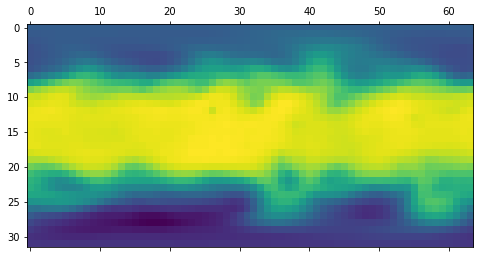

In [110]:
plt.matshow(X[0, :, :, 0])

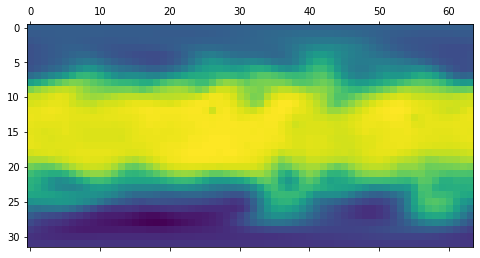

In [111]:
plt.matshow(X[0, :, :, 15])

In [112]:
from src.data_generator import create_predictions
preds = create_predictions(model, dg_test)

In [116]:
from src.score import compute_weighted_rmse, load_test_data
# Load the validation subset of the data: 2017 and 2018
z500_valid = load_test_data(f'{DATADIR}geopotential_500', 'z')
t850_valid = load_test_data(f'{DATADIR}temperature_850', 't').drop('level')
valid_data = xr.merge([z500_valid, t850_valid])

In [117]:
print(compute_weighted_rmse(preds.z, z500_valid).load())

print(compute_weighted_rmse(preds.t, t850_valid).load())

<xarray.DataArray 'z_rmse' ()>
array(471.45684257)
Coordinates:
    level    int32 500
<xarray.DataArray 't_rmse' ()>
array(2.35866324)
